In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import jax.numpy as jnp
import numpy as np
import jax
from tueplots import bundles
from tueplots.constants.color import rgb
import matplotlib.pyplot as plt
import pandas as pd

import pymc as pm
from pymc.gp import Latent
from pymc.gp.cov import RatQuad, ExpQuad, Periodic, WhiteNoise
from pymc.gp.mean import Constant

from jax import grad, hessian
from scipy import optimize

import numpyro
numpyro.set_host_device_count(4)
jax.config.update('jax_platform_name', 'cpu')
#jax.config.update("jax_enable_x64", True)
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({'figure.dpi': 300})
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

from utils import Gaussian
from utils import gp
from utils.bayes.media_transforms import shape, adstock
from utils.datagen import load_gt_data, gt_data_to_impressions, make_dataset, add_time_trend

In [33]:
cp_terms = load_gt_data("./data/cpshake_gt.csv")
cp_terms["protein_shake_core_power"] = np.clip(cp_terms["protein_shake_core_power"], 1, 1_000)
cp_terms["core_power_protein"] = np.clip(cp_terms["core_power_protein"], 1, 1_000)
impressions = gt_data_to_impressions(cp_terms, 'core_power_protein')
impressions = gt_data_to_impressions(impressions, 'protein_shake_core_power', scale=2_000)
impressions = add_time_trend(impressions)

In [40]:
impressions.head()

,week,core_power_protein,protein_shake_core_power,t
0,2019-12-29,170275,19919,1
1,2020-01-05,169620,15695,2
2,2020-01-12,213748,16132,3
3,2020-01-19,198966,20087,4
4,2020-01-26,189130,11946,5


In [34]:
(
  media_data, 
  impression_data, 
  click_data, 
  ctr_logit,
  params
 ) = make_dataset(impressions, 'core_power_protein', 'protein_shake_core_power', 't')


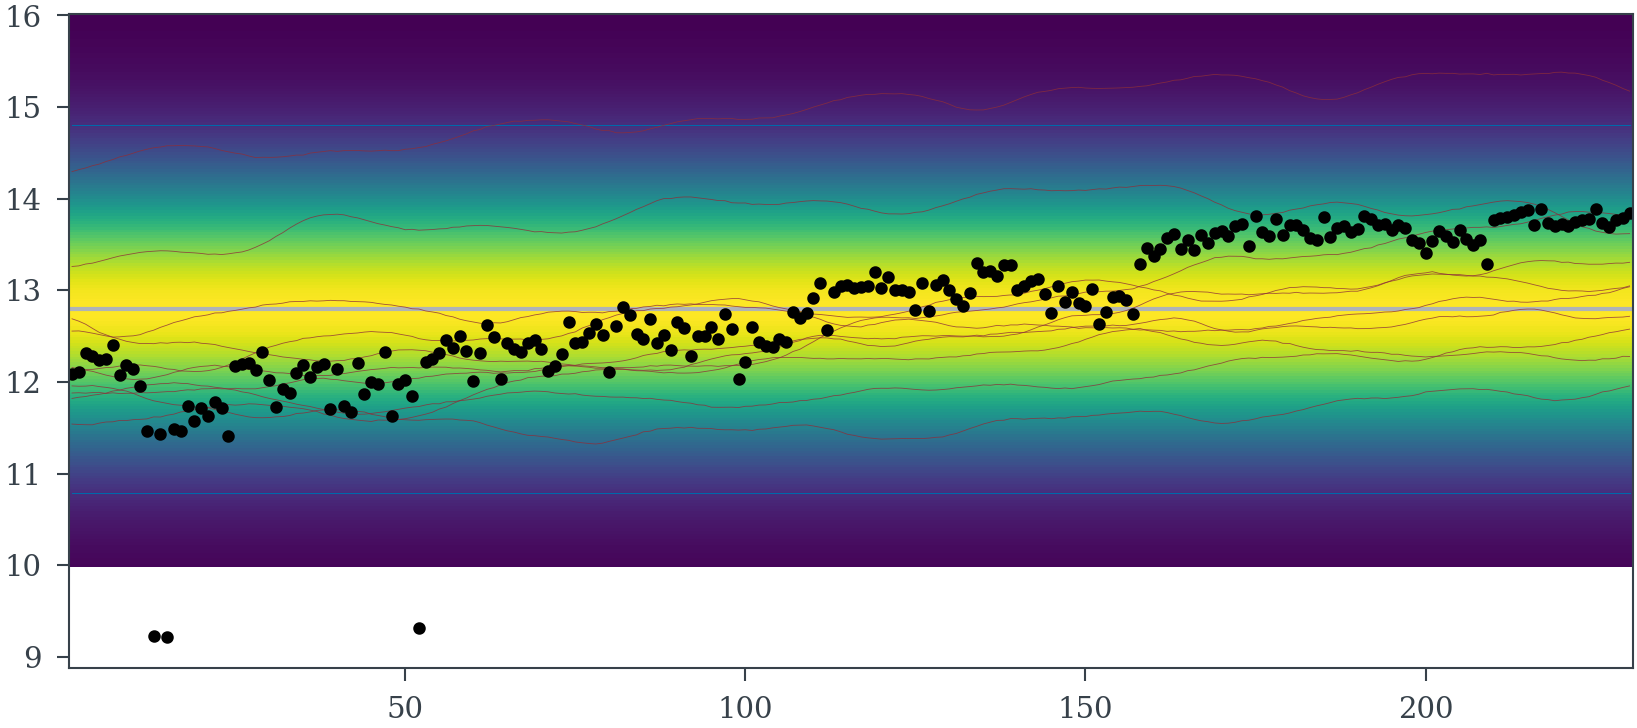

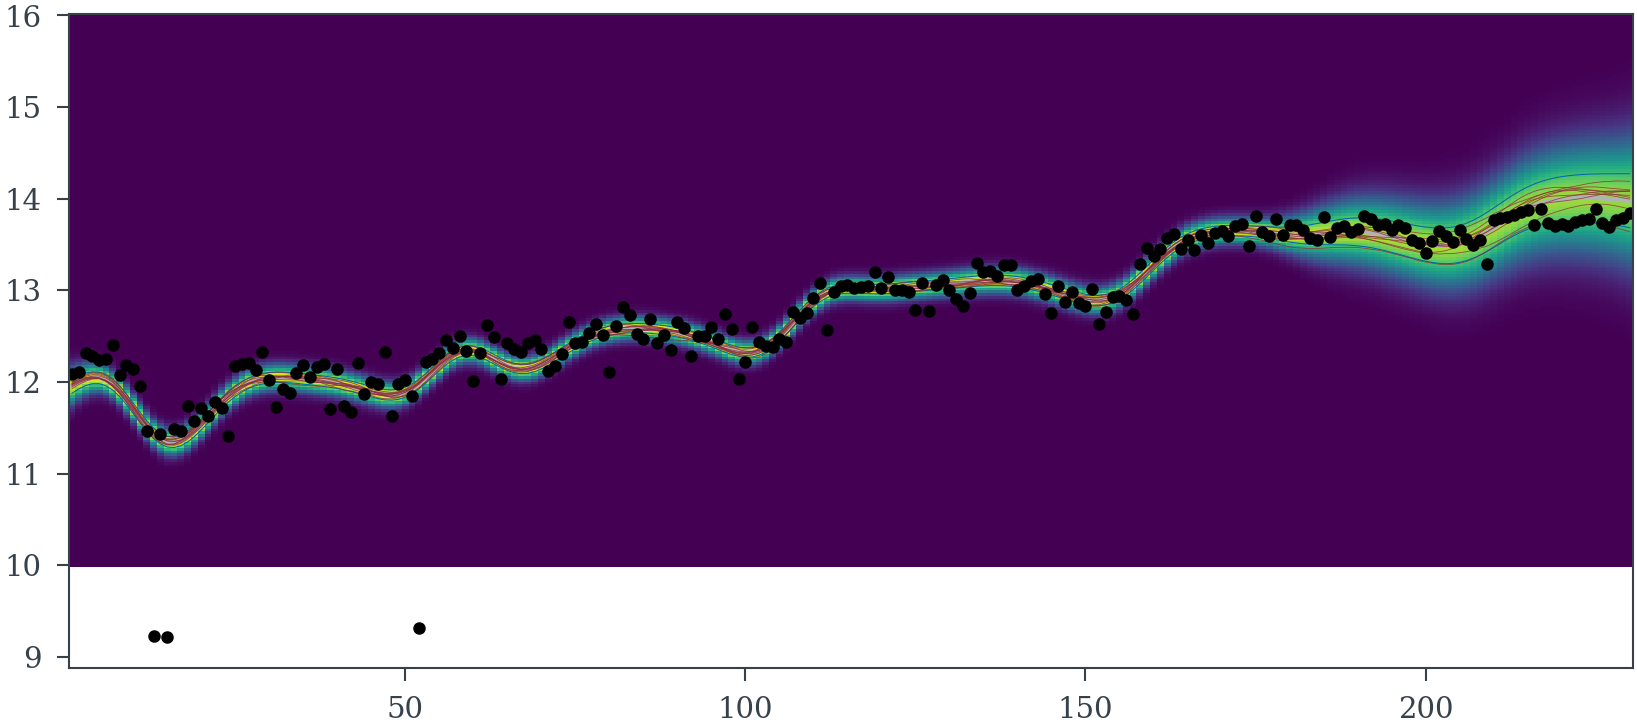

In [36]:
long_term_trend = gp.SEKernel(52.18*3, 1)
shot_term_trend = gp.RQKernel(52.18, 1.2, 0.05)
noise = gp.WhiteNoiseKernel(0.001)
periodic = gp.PeriodicKernel(1.0, 52.18, 1)*gp.SEKernel(52.18*1.75, .1)

kernel = long_term_trend + shot_term_trend + noise + periodic
constant_mean = gp.ConstantMean(np.mean(np.log(impression_data)))
gp_model = gp.GaussianProcess(constant_mean, kernel)
fig, ax = plt.subplots()
gp_model.plot(ax, impressions['t'].values[:, None], yrange=(10, 16),gamma=1, num_samples=10, rng_key=jax.random.PRNGKey(0))
ax.plot(impressions['t'], np.log(impression_data), 'o', color='black', markersize=2)

fig, ax = plt.subplots()
conditioned_model = gp_model.condition(impressions['t'].values[:-50, None], np.log(impression_data)[:-50], sigma=.01)
conditioned_model.plot(ax, impressions['t'].values[:, None], yrange=(10, 16), num_samples=10, rng_key=jax.random.PRNGKey(0))
ax.plot(impressions['t'], np.log(impression_data), 'o', color='black', markersize=2)

In [46]:
import matplotlib as mpl
import matplotlib.cm as cm


Array(nan, dtype=float32)

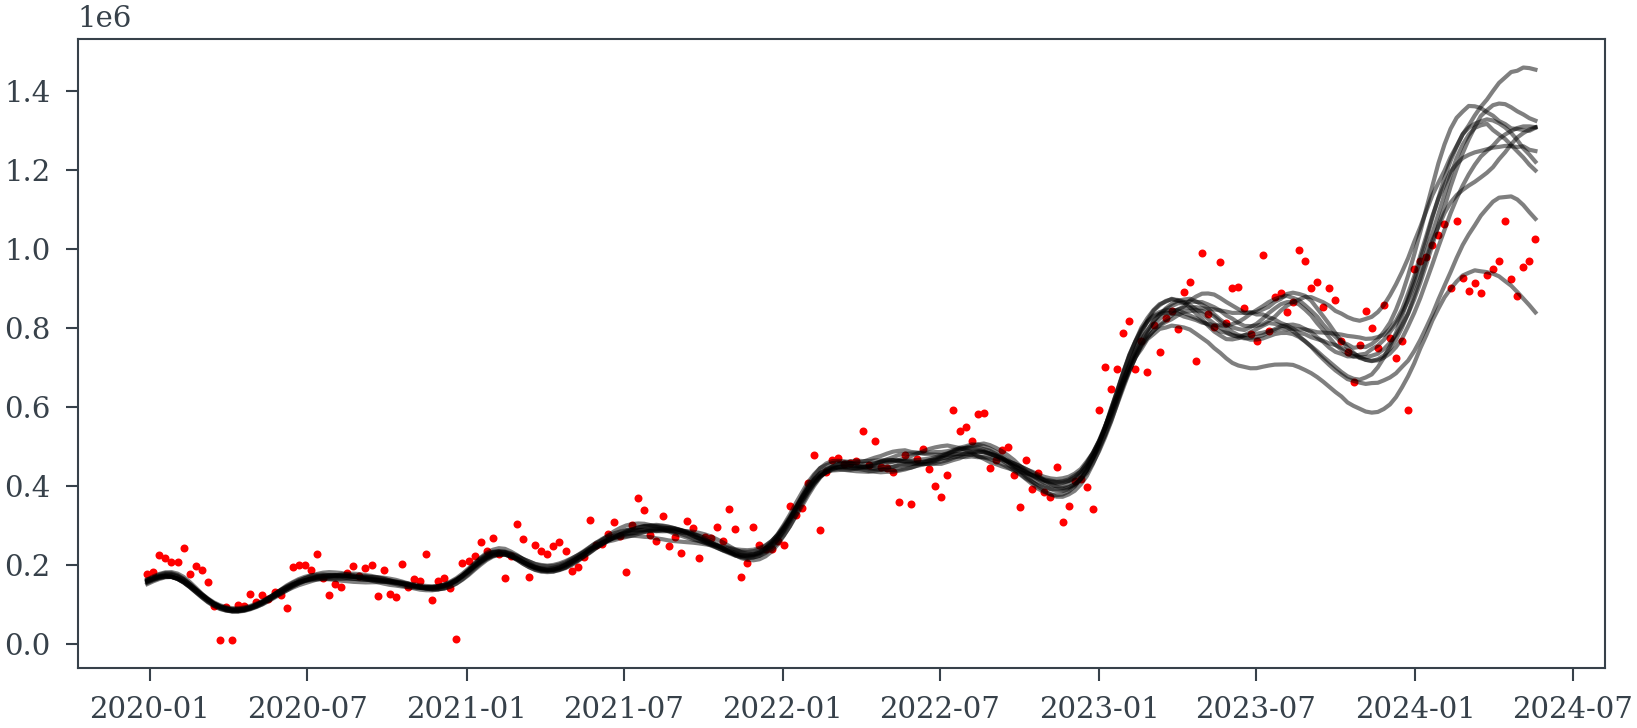

In [48]:
estimates = conditioned_model(impressions['t'].values[:, None]).sample(jax.random.PRNGKey(0), 10)
plt.plot(impressions['week'], np.exp(estimates.T), color='k', alpha=0.5)
plt.scatter(impressions['week'], impression_data, color='red', s=2)